In [2]:
import pandas as pd
import numpy as np
import re
import emoji
import preprocessor as p
from matplotlib import pyplot as plt
from matplotlib import rcParams
import japanize_matplotlib
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Panel, Tabs, FactorRange
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.palettes import Spectral5
import bokeh.layouts as layouts
from bokeh.layouts import row
import bokeh.models.widgets as widgets
from bokeh.io import curdoc
from bokeh.transform import factor_cmap
from bokeh.transform import dodge
import plotly.graph_objects as go
output_notebook()
# Set iPython's max column width to 1000
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.0f}'.format

Loading BokehJS ...

In [3]:
#load in the dataframe
df = pd.read_json('distweets.json')

In [4]:
#clean up text write as a function 
#Remove RT and links from full_text this was already done for the translated text when translating .
#p.set_options(p.OPT.URL, p.OPT.MENTION,p.OPT.HASHTAG,p.OPT.RESERVED,p.OPT.NUMBER)
clean = p.clean
df['clean_text_count'] = [clean(x) for x in df['full_text']]
df['tran_clean_text_count'] = [clean(x) for x in df['tran_full_text']]


#put everything to lowercase 
df['clean_text_count'] = [x.lower() for x in df['clean_text_count']]
df['tran_clean_text_count'] = [x.lower() for x in df['tran_clean_text_count']]


#remove punctuations, digitis, triple periods and japanese punctuations and japanese emojis 
punc = lambda x: re.sub("!|,|\?|\'|-|\"|&|。|\)|\(|！|，|\.*|/|\[|\]|\u2026|\d|:|~|、|？|☆|’|– |【|】|「|」|《|》|※| “|”|＊|→||[\b\.\b]{3}||@||@ |#|# |", '',x)
df['clean_text_count']= [punc(x) for x in df['clean_text_count']]
df['tran_clean_text_count'] = [punc(x) for x in df['tran_clean_text_count']]


#remove emoji 
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
rem_emoji = lambda x: re.sub(r,'',x)
df['clean_text_count']= [rem_emoji(x) for x in df['clean_text_count']]
df['tran_clean_text_count'] = [rem_emoji(x) for x in df['tran_clean_text_count']]


#remove short words for english and translated portions
short_words = lambda x: ' '.join([w for w in x.split() if len(w)>3])
df['clean_text_count'] = np.where(df['lang'] == 'en', [short_words(x) for x in df['clean_text_count']], [x for x in df['clean_text_count']])
df['tran_clean_text_count'] = [short_words(x) for x in df['tran_clean_text_count']]
df['en_ja_txt_count'] = np.where(df['tran_clean_text_count'] != '', df['tran_clean_text_count'], df['clean_text_count'])

In [5]:
#split japanese data and english data
df_ja = df[df['lang'] == 'ja']
df_en = df[df['lang'] == 'en']

In [6]:
#Function for our top 20 data later on 
def top20(data):
    txthash = data.str.split(expand = True).iloc[:, :].astype(str)
    
    for col in txthash:
        txthash[col] = txthash[col].str.strip('\'" ')
        txthash[col] = txthash[col].str.strip('""')
        txthash[col] = txthash[col].str.strip('#')
        txthash[col] = txthash[col].str.strip('[]')
        txthash[col] = txthash[col].str.strip('\'\"')
        txthash[col] = txthash[col].str.strip("''")
        txthash[col] = txthash[col].str.strip("',")
        txthash[col] = txthash[col].str.strip('None')
        txthash[col] = txthash[col].str.strip('nan')
    list1= []
    for col in txthash:
        list1.append(txthash[col].dropna())

    list2 = []

    for i in range(len(list1)):
        list2 += list1[i].tolist()

    _count = pd.DataFrame(list2).replace('', np.NaN).dropna(how='all')
    _count = _count.rename(columns = {0:'hashtag'})
    top20data = _count['hashtag'].value_counts().head(20)
    top20data = top20data.astype(str)
    top20data = top20data.str.extractall('(\d+)')
    top20data.reset_index(inplace = True)
    top20data.drop(columns = 'match', inplace = True)
    top20data.rename(columns = {'level_0':'hashtag', 0: 'count'}, inplace = True)
    return top20data

### Word Cloud of words commonly used between Japanese and English Users

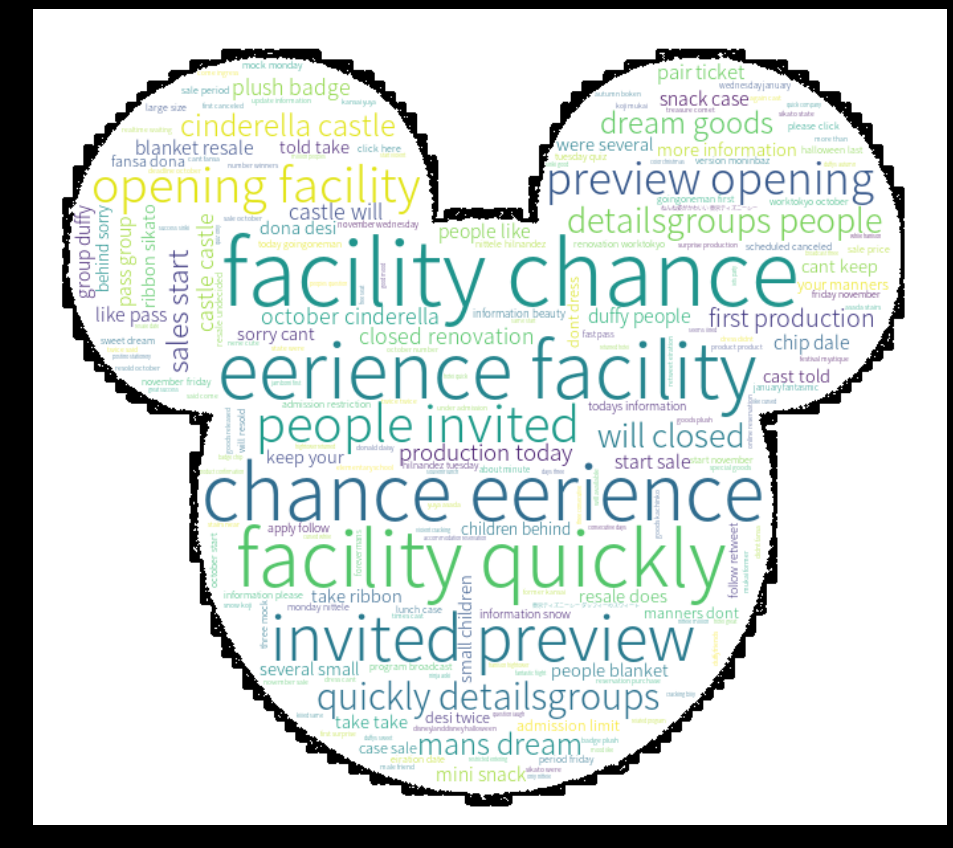

In [19]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
#Japanese Language User word cloud using the translated text for Japanese Users 
font_path = 'font/NotoSansCJKjp-Light.otf'

df_ja['en_ja_txt_count'] = df_ja['en_ja_txt_count'].astype(str)
#Japanese User Data

stop_words_t = ['disneyland','THIS','forum','disney','going','time','resort','tokyo','paris','california','disneysea','florida','disneylands','youre',
                 'mouse','anaheim','disneys','parks','angeles', '𝚃𝙷𝙸𝚂', 'park', 'forwarding', 'fortified', 'just', 'forward','𝙻𝙾𝙾𝙺','forwardlike','forthcoming',
                 'youd', 'world', 'year', 'week', 'day', 'mickey', 'tdr', 'tdr_md', 'minnie' ,'forums', 'forththey', 'forwinnie', '𝙥𝙤𝙨𝙩𝙚𝙙', 'forth', 'forwith',
                 'gran', 'graclas', 'gras', 'grafrom', 'tdr_now','wwwwww', 'gotten', 'graba', 'urayasu', 'android', 'atdisneyland', 'from', 'this','with',
               'that','because', 'have', 'chiba', 'there', 'zhao', 'land']


cinder = np.array(Image.open('img/mickey.png'))


# Read the whole text.
text_ja = ''.join(tweet for tweet in df_ja.en_ja_txt_count)
wc = WordCloud(background_color = 'white', max_words = 200, stopwords=stop_words_t, width=1600, height=800,\
                      contour_width = 2,contour_color ='black', mask = cinder, font_path=font_path)
wc.generate(text_ja)

plt.figure(figsize=(30,15),  facecolor='k')
plt.imshow(wc,  interpolation ='bilinear')
plt.axis("off")

plt.show()

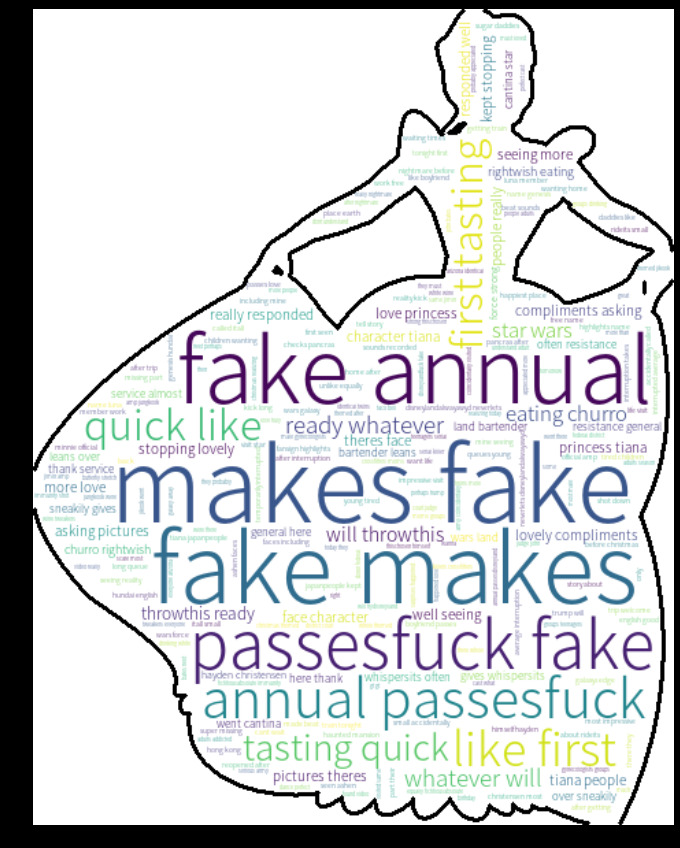

In [20]:
#English Language User word cloud 
df_en['clean_text_count'] = df_en['clean_text_count'].astype(str)

cinder = np.array(Image.open('img/cinder.png'))

add_stop_words = ['disneyland','THIS','forum','disney','going','time','resort','tokyo','paris','california','disneysea','florida','disneylands','youre',
                 'mouse','anaheim','disneys','parks','angeles', '𝚃𝙷𝙸𝚂', 'park', 'forwarding', 'fortified', 'just', 'forward','𝙻𝙾𝙾𝙺','forwardlike','forthcoming',
                 'youd', 'world', 'year', 'week', 'day', 'forums', 'forththey', 'forwinnie', '𝙥𝙤𝙨𝙩𝙚𝙙', 'forth', 'forwith', 'fortnights','fortnight','fortnite',
                  'fortitude','fortress','fortunate','fort','fortunately','fortune','forsure','forwar','forwards','𝙘𝙩𝙤𝙗𝙚𝙧','forzen','forsee','foshan','forrest', 
                  'fosho','foster', 'forreal', 'this','with', 'that', 'been', 'have', 'from','when','japan', 'into','your']

# Read the whole text.
text_en = ''.join(tweet for tweet in df_en.clean_text_count)
wc = WordCloud(background_color = 'white', max_words = 500, stopwords=add_stop_words, width=1600, height=800,\
                      contour_width = 2,contour_color ='black', mask = cinder, font_path=font_path)
wc.generate(text_en)

plt.figure(figsize=(30,15),  facecolor='k')
plt.imshow(wc,  interpolation ='bilinear')
plt.axis("off")

plt.show()

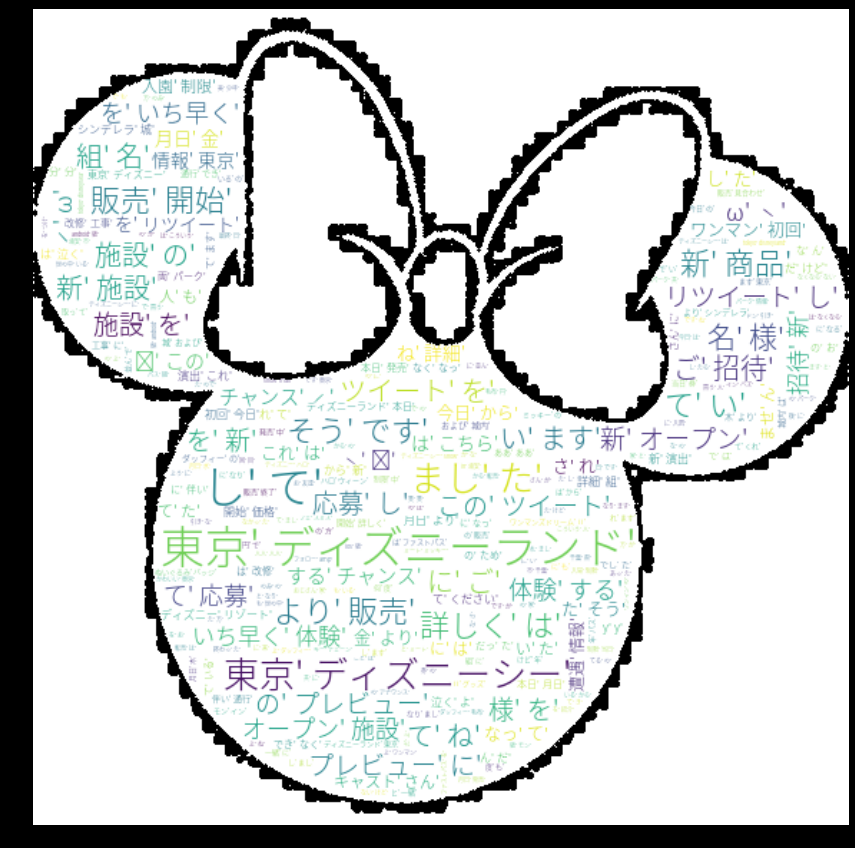

In [25]:
#Japanese Language User word cloud 
import MeCab
m = MeCab.Tagger("-O wakati")
text = df_ja['clean_text_count']
text = list(text)
text = [m.parse(x).split() for x in text]
df_ja['clean_text_count_tokens'] = text

df_ja['clean_text_count_tokens'] = df_ja['clean_text_count_tokens'].astype(str)




#Japanese User Data

stop_words_ja = ['東京','ディズニーシー','ディズニー','𝕃𝕒𝕟𝕕','ディズニーランド','けど','イン','です', '𝔻𝕚𝕤𝕟𝕖𝕪','in','ios','android','浦安','リゾート','disneyland',
                '今日', 'この', 'ので', 'さん', 'at', 'im', 'disneysea', 'ミッキー', 'tdr', 'ミニー', 'tokyo','𝐷𝑖𝑠𝑛𝑒𝑦','https', '𐤔𐤔', 'it', 'to', 'th', 'ﾟﾟ',
                'から', 'たら', 'これ', '千葉', 'ある', 'って', 'する', 'シー', 'ちゃん', 'でも', 'モン', 'まし', 'そう', 'いる', 'だっ', 'でき', 'てる', 'すぎ', 'なら',
                'より', 'ため', 'ランド', 'まで','じゃ']


cinder = np.array(Image.open('img/minnie.png'))


# Read the whole text.
text_ja = ''.join(tweet for tweet in df_ja.clean_text_count_tokens)
wc = WordCloud(background_color = 'white', max_words = 500, stopwords=stop_words_ja, width=1600, height=800,\
                      contour_width = 2,contour_color ='black', mask = cinder, font_path=font_path)
wc.generate(text_ja)

plt.figure(figsize=(30,15),  facecolor='k')
plt.imshow(wc,  interpolation ='bilinear')
plt.axis("off")

plt.show()

### Tweet Map of Micro Influencers and Influencers

In [8]:
#import translated dsv for Japanese users
df_ja = df_ja.reset_index(drop = True)
df_trans= pd.read_json('user_tran_loc.json')
df_trans = df_trans['trans_text']
df_ja['translated_user_location'] = df_trans

In [9]:
#Subset the dataframe for our map 
df_en.reset_index(drop= True, inplace = True)
en_loc = df_en.loc[:,['user_location','lang','user_fol_count','user_fr_count','user_fav_count','user_screen_name','full_text',
                     'retweet']]
#micro influencer rule 1000 plus followers
en_loc = en_loc[en_loc['user_fol_count'] >1000]
ja_loc = df_ja.loc[:,['translated_user_location','lang','user_fol_count','user_fr_count','user_fav_count','user_screen_name',
                      'tran_full_text','retweet']]
#micro influencer rule 800 plus followers
ja_loc = ja_loc[ja_loc['user_fol_count'] >800]

In [10]:
#drop all none data 
en_loc = en_loc.dropna().reset_index(drop =True)
ja_loc = ja_loc.dropna().reset_index(drop = True)

In [11]:
#lowercasing to match city column 
en_loc['user_location'] = [x.lower() for x in en_loc.user_location]
ja_loc['translated_user_location'] = [x.lower() for x in ja_loc.translated_user_location]

In [12]:
#only keeping letters in the string
letters = lambda s: re.sub('[^a-zA-Z]+', ' ', s)
en_loc['user_location'] = [letters(x) for x in en_loc.user_location]
ja_loc['translated_user_location'] = [letters(x) for x in ja_loc.translated_user_location]

In [13]:
en_loc.drop_duplicates('user_screen_name',inplace = True)
ja_loc.drop_duplicates('user_screen_name', inplace = True)
en_loc = en_loc.sort_values(by=['user_fol_count'], ascending=False)
ja_loc = ja_loc.sort_values(by = ['user_fol_count'], ascending = False)

In [14]:
en_loc3000 = en_loc[2001:3001]
ja_loc3000 = ja_loc[2001:3001]
en_loc3000.to_csv('en_loc3000.csv')
ja_loc3000.to_csv('ja_loc3000.csv')

In [54]:
# # Geocoder api 
# # https://didaskalia-jpc.blogspot.com/2019/02/getting-longitude-latitude-coordinates.html?m=1
# from opencage.geocoder import OpenCageGeocode
# from pprint import pprint
# key = 'cc4b416ff80b4693afa4dda3e713941e' # get api key from:  https://opencagedata.com
# geocoder = OpenCageGeocode(key)


# en_lat = []   # create empty lists
# en_long = []

# for x in en_loc3000.user_location: # iterate over rows in dataframe 
#     try:
#         query = x
#         results = geocoder.geocode(query)   
#         lat = results[0]['geometry']['lat']
#         long = results[0]['geometry']['lng']
#         en_lat.append(lat)
#         en_long.append(long)
#     except IndexError:
#         en_lat.append(np.nan)
#         en_long.append(np.nan)

In [ ]:
# #Japanese users lat and long 
# from opencage.geocoder import OpenCageGeocode
# from pprint import pprint
# key = 'cc4b416ff80b4693afa4dda3e713941e' # get api key from:  https://opencagedata.com
# geocoder = OpenCageGeocode(key)

# ja_lat = []   # create empty lists
# ja_long = []

# for x in ja_loc3000.translated_user_location: # iterate over rows in dataframe 
#     try:
#         query = x
#         results = geocoder.geocode(query)   
#         lat = results[0]['geometry']['lat']
#         long = results[0]['geometry']['lng']
#         ja_lat.append(lat)
#         ja_long.append(long)
#     except IndexError:
#         ja_lat.append(np.nan)
#         ja_long.append(np.nan)

In [37]:
#load in geodata 
en_loc = pd.read_csv('en_loc.csv')
ja_loc = pd.read_csv('ja_loc.csv')
#load in last 1000 data from excel file 
en_loc3 = pd.read_csv('en_loc3000.csv')
ja_loc3 = pd.read_csv('ja_loc3000.csv')
en_loc.rename(columns = {'latitude ': 'latitude'}, inplace = True)

#Stack the dataframes
en_loc = [en_loc,en_loc3]
en_loc= pd.concat(en_loc).reset_index(drop=True)
ja_loc = [ja_loc,ja_loc3]
ja_loc= pd.concat(ja_loc).reset_index(drop=True)

(3000, 11)

In [41]:
#formating the longitude and latitude for first 2000 data points and dropping NaNs 
en_loc['latitude'] = en_loc['latitude'].str.replace(',', '')
en_loc['longitude'] = en_loc['longitude'].str.replace(',', '')
ja_loc['latitude'] = ja_loc['latitude'].str.replace(',', '')
ja_loc['longitude'] = ja_loc['longitude'].str.replace(',', '')
en_loc.rename(columns = {'latitude ': 'latitude'}, inplace = True)
ja_loc['latitude'] = ja_loc['latitude'].str.replace(',', '')
en_loc['latitude'] = en_loc['latitude'].replace([' nan'], np.nan)
en_loc['latitude'] = en_loc['latitude'].replace(['nan'], np.nan)
en_loc['longitude'] = en_loc['longitude'].replace(['nan'], np.nan)
en_loc['longitude'] = en_loc['longitude'].replace([' nan'], np.nan)
en_loc.dropna(inplace = True)
ja_loc['latitude'] = ja_loc['latitude'].replace([' nan'], np.nan)
ja_loc['latitude'] = ja_loc['latitude'].replace(['nan'], np.nan)
ja_loc['longitude'] = ja_loc['longitude'].replace(['nan'], np.nan)
ja_loc['longitude'] = ja_loc['longitude'].replace([' nan'], np.nan)
ja_loc.dropna(inplace = True)

en_loc['longitude'] = en_loc['longitude'].apply(pd.to_numeric, errors='coerce')
en_loc['latitude'] = en_loc['latitude'].apply(pd.to_numeric, errors='coerce')
ja_loc['latitude'] = ja_loc['latitude'].apply(pd.to_numeric, errors='coerce')
ja_loc['longitude'] = ja_loc['longitude'].apply(pd.to_numeric, errors='coerce')

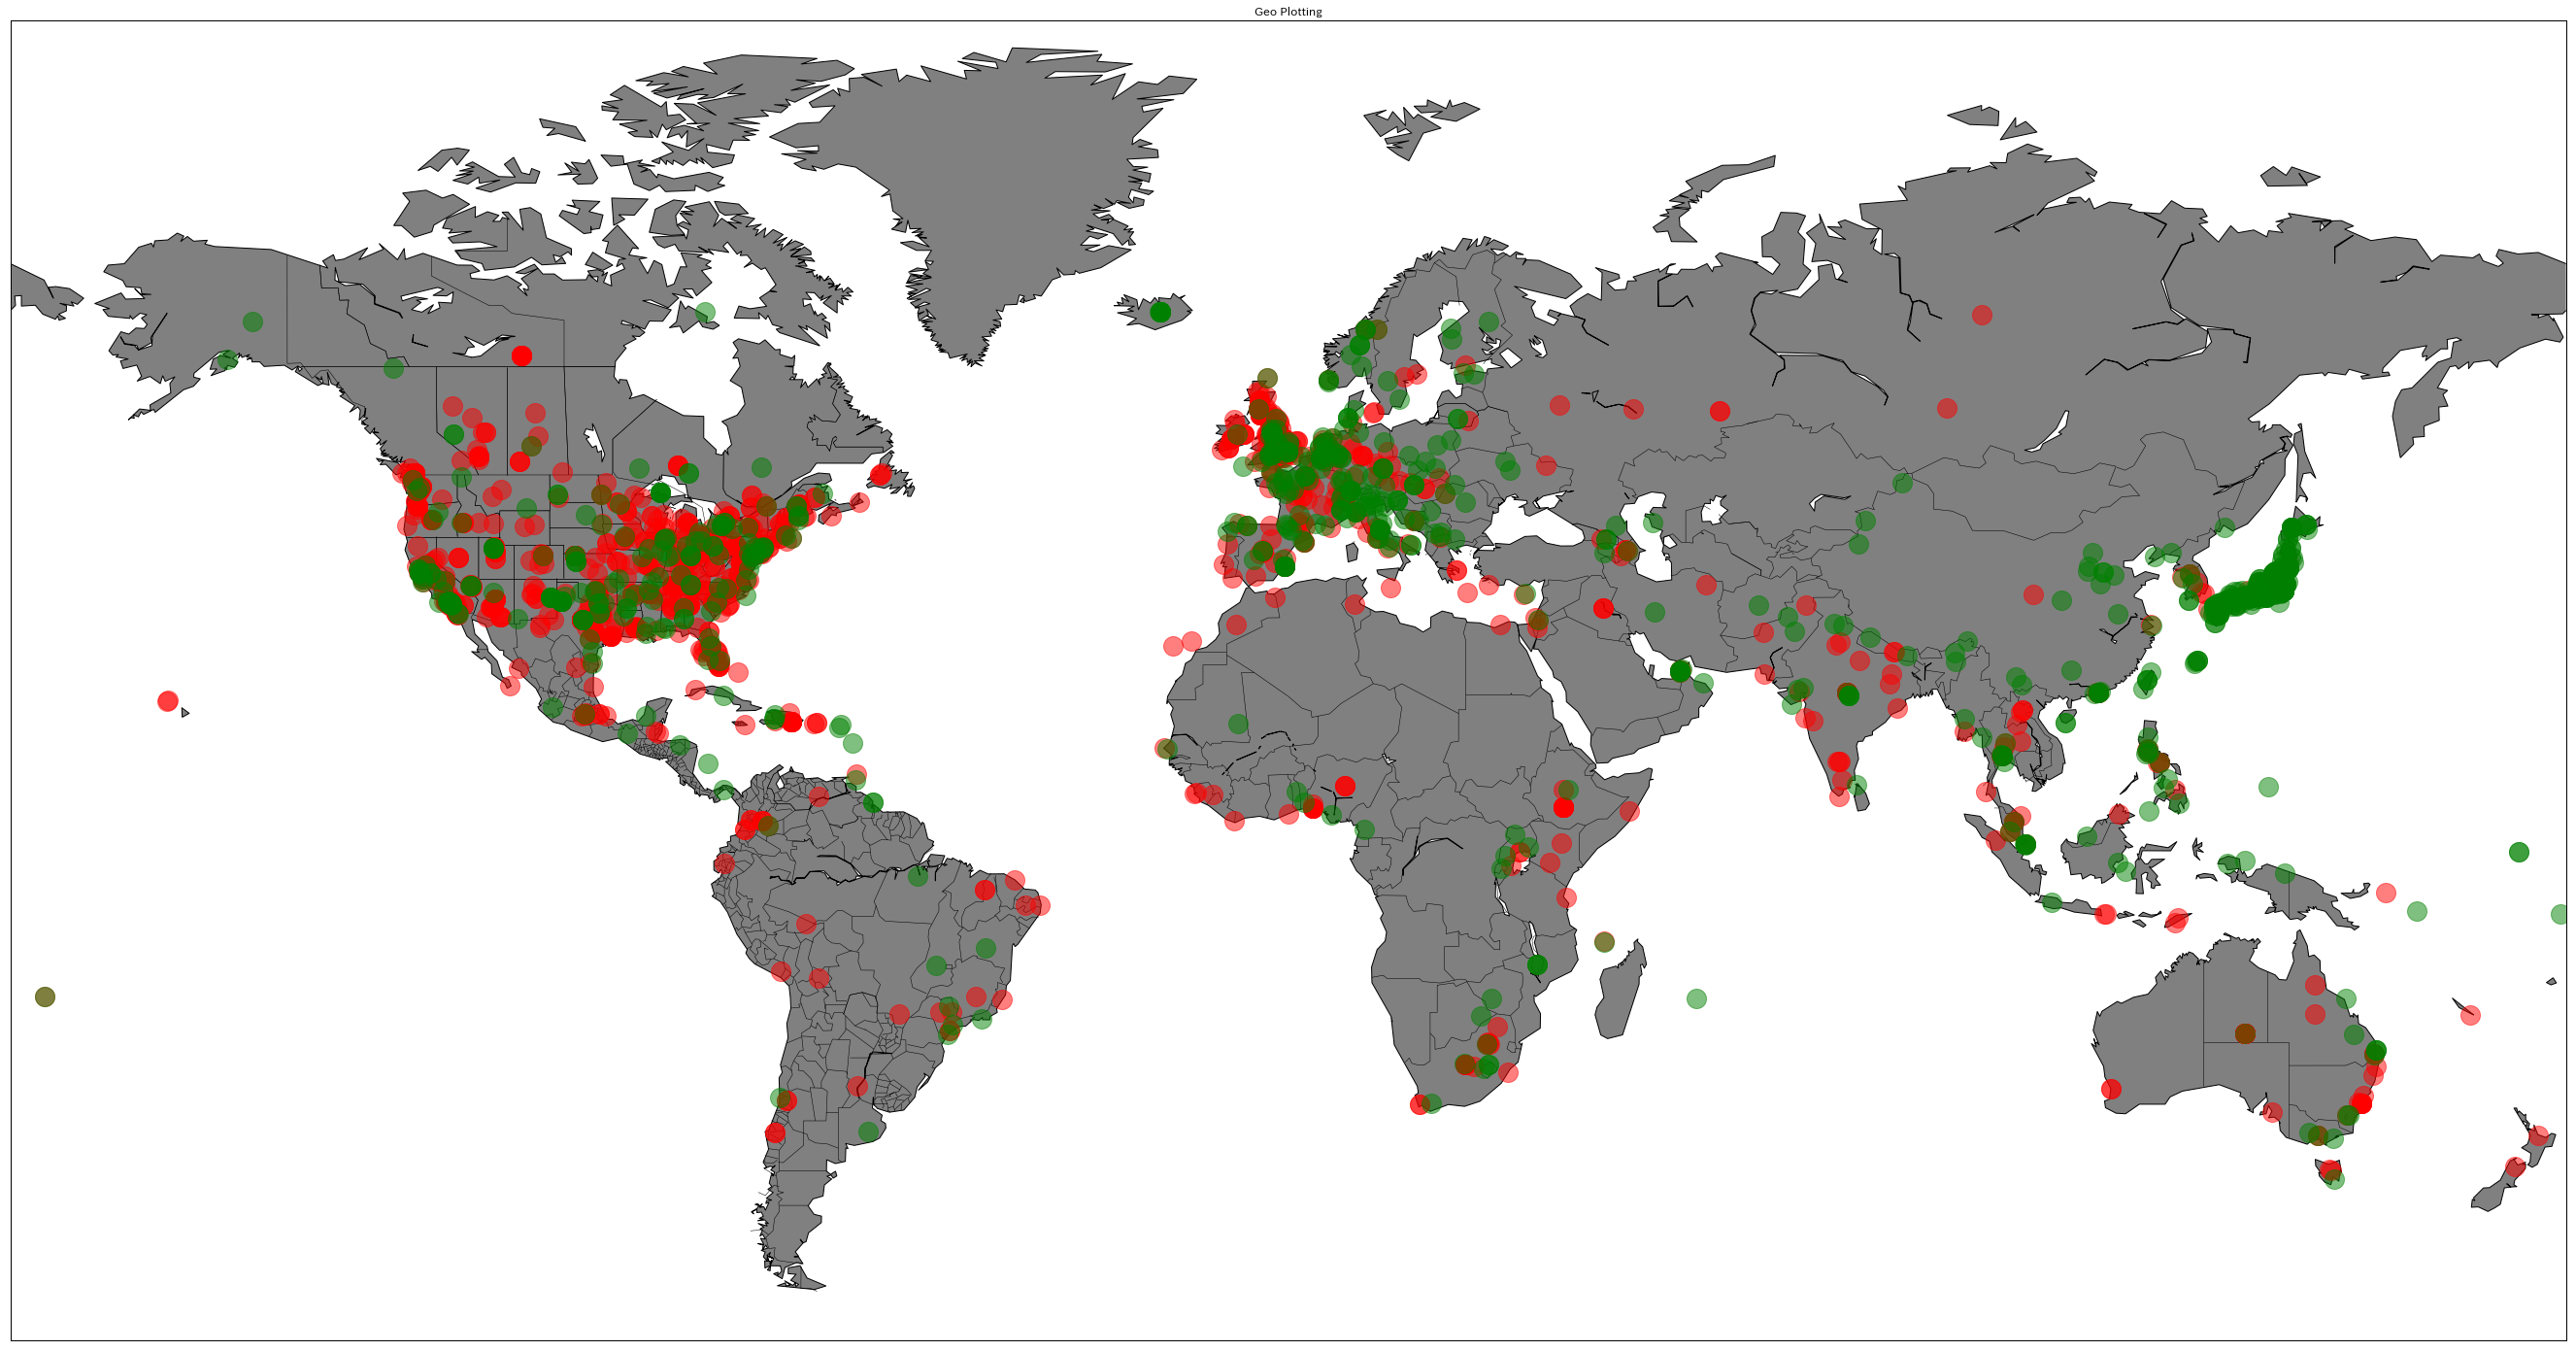

In [18]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize = (50,25))


m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=85,llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.fillcontinents(color='gray')
m.drawmapboundary(fill_color='#FFFFFF')

lat_en= list(en_loc['latitude'])
lon_en = list(en_loc['longitude'])


lat_ja = list(ja_loc['latitude'])
lon_ja = list(ja_loc['longitude'])

x,y = m(lon_en,lat_en)
m.plot(x,y,'ro',markersize=20,alpha=.5)

x,y = m(lon_ja,lat_ja)
m.plot(x,y,'go',markersize=20,alpha=.5)

plt.title('Geo Plotting')
plt.show()

In [30]:
en_info = en_loc.loc[:,['user_screen_name', 'lang', 'user_fol_count', 'user_fav_count','full_text','longitude','latitude']].reset_index(drop=True)
ja_info = ja_loc.loc[:,['user_screen_name', 'lang', 'user_fol_count', 'user_fav_count','tran_full_text','longitude','latitude']].reset_index(drop=True)

In [34]:
en_info_list = []
for y in range(0,2663):
    en_info_list.append((f"Screenname: {en_info['user_screen_name'][y]}, Fol_count: {en_info['user_fol_count'][y]}, Fav_count: {en_info['user_fav_count'][y]}"))

ja_info_list = []
for y in range(0,2047):
    ja_info_list.append((f"Screenname: {ja_info['user_screen_name'][y]}, Fol_count: {ja_info['user_fol_count'][y]}, Fav_count: {ja_info['user_fav_count'][y]}"))

1781

In [22]:
lat = list(en_info['latitude'])
lon = list(en_info['longitude'])

lat2 = list(ja_info['latitude'])
lon2 = list(ja_info['longitude'])

In [42]:
import folium

map_ = folium.Map(location = [35.6267, 139.8851], zoom_start = 6,tiles = "Stamen Terrain")
fg = folium.FeatureGroup(name = 'My Map')
fg1 = folium.FeatureGroup(name = 'My Map')

for lt, ln, info in zip(lat,lon,en_info_list):
    fg.add_child(folium.Marker(location =[lt, ln], popup = info, icon = folium.Icon(color ='blue' )))

for lt, ln, info in zip(lat2,lon2,ja_info_list):
    fg1.add_child(folium.Marker(location =[lt, ln], popup = info, icon = folium.Icon(color ='red' )))

map_.add_child(fg)
map_.add_child(fg1)
map_.save('twittermap.html')

### Mentions, Emojis, Source and hashtags

In [43]:
#Top sources for Japanese and English Users 
dfja_plot = df_ja.groupby(['lang', 'source']).size().reset_index()
dfja_plot = dfja_plot.sort_values(0,ascending = False).head(10)
dfen_plot = df_en.groupby(['lang', 'source']).size().reset_index()
dfen_plot = dfen_plot.sort_values(0,ascending = False).head(10)
dfja_plot.rename(columns={0:'count'}, inplace=True)
dfen_plot.rename(columns={0:'count'}, inplace=True)


#Merged between Japanese and English Users 
merged = dfja_plot.merge(dfen_plot,how='outer', left_on='source', right_on='source')
merged.drop(['lang_x','lang_y'], axis = 1, inplace = True)
merged.rename(columns={'count_x':'count_ja','count_y':'count_en'}, inplace=True)
merged = merged.replace(np.nan,0)

In [44]:
#English Users 
device = list(dfen_plot['source'])
counts = list(dfen_plot['count'])
max_count = int(max(dfen_plot['count']))

source = ColumnDataSource(data=dict(device=device, counts=counts))

p = figure(x_range=device, y_range=(0,max_count+2000),  plot_width=900, plot_height=700, title="Device Counts top 10 English Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p.vbar(x='device', top='counts', width=0.9, color = 'teal', source=source)
p.title.align = 'center'
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"
p.left[0].formatter.use_scientific = False
p.add_tools(HoverTool(tooltips=[("Twitter Device", "@device"), ("Total Count", "@counts")]))


tab1 = Panel(child=p, title="Top 10 Twitter Device English Users")

p.title.text_font_size = '20pt'
p.xaxis.axis_label="Device Name"
p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font = "times"
p.xaxis.axis_label_text_color = "black"


p.yaxis.axis_label="Count"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font = "times"
p.yaxis.axis_label_text_color = "black"


#Japanese Users 
device1 = list(dfja_plot['source'])
counts1 = list(dfja_plot['count'])
max_count1 = int(max(dfja_plot['count']))

p1 = figure(x_range=device1, y_range=(0,max_count1+2000),  plot_width=900, plot_height=700, title="Device Counts top 10 Japanese Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")



source1 = ColumnDataSource(data=dict(device=device1, counts=counts1))


p1.vbar(x='device', top='counts', width=0.9, color = 'lightsteelblue', source=source1)
p1.title.align = 'center'
p1.xgrid.grid_line_color = None
p1.xaxis.major_label_orientation = "vertical"
p1.left[0].formatter.use_scientific = False
p1.add_tools(HoverTool(tooltips=[("Twitter Device", "@device"), ("Total Count", "@counts")]))
tab2 = Panel(child=p1, title="Top 10 Twitter Device Japanese Users")

p1.title.text_font_size = '20pt'
p1.xaxis.axis_label="Device Name"
p1.xaxis.axis_label_text_font_size = "15pt"
p1.xaxis.major_label_text_font_size = "15pt"
p1.xaxis.axis_label_text_font = "times"
p1.xaxis.axis_label_text_color = "black"

p1.yaxis.axis_label="Count"
p1.yaxis.axis_label_text_font_size = "15pt"
p1.yaxis.major_label_text_font_size = "15pt"
p1.yaxis.axis_label_text_font = "times"
p1.yaxis.axis_label_text_color = "black"


#Japanese and English Users merged 
devices2 = merged['source']
languages = ['JA','ENG']

data = {'devices' : devices2,
        'ja': merged['count_ja'],
        'en': merged['count_en']}



x = [ (dev, lang) for dev in devices2 for lang in languages]
counts = sum(zip(data['ja'], data['en']), ()) # like an hstack

source = ColumnDataSource(data=dict(x=x, counts=counts))

p2 = figure(x_range=FactorRange(*x),  plot_width=1500, plot_height=700, title="Top 10 Devices Counts by Language User",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")

p2.vbar(x='x', top='counts', width=0.9, source=source, fill_color=factor_cmap('x', palette=['lightsteelblue','teal'], factors=languages, start=1, end=2))

p2.y_range.start = 0
p2.add_tools(HoverTool(tooltips=[("Twitter Device", "@x"), ("Total Count", "@counts")]))

p2.xgrid.grid_line_color = None
p2.left[0].formatter.use_scientific = False
p2.xaxis.major_label_orientation = 0.3
p2.x_range.range_padding = 0.03


p2.xgrid.grid_line_color = None
p2.title.align = 'center'

p2.title.text_font_size = '20pt'
tab3 = Panel(child=p2, title="Top 10 Twitter Device Japanese/English Users")



tabs = Tabs(tabs=[ tab1, tab2, tab3])
show(tabs)



In [45]:
#Japanese Users 
top20hashtag = top20(df_ja.text_hashtags)

#Add in translation as column to have it switch in bokeh 
translated_hashtag = ['tdr_now', 'tdr_md', 'Disneyland', 'Disney', 'Disney Sea', 'jal preview ticket campaign', 'Tokyo Disneyland®','I have a park ticket 🎁', 
                      'disneyland', 'disney', 'tdl', 'tdr_inf','Tokyo Disneyland','d halo', 'Culture', 'Overseas celebrity gossip', 
                      'Overseas celebrities','Gossip','Tokyo Disney Sea', 'tds'] 
top20hashtag['translated_hashtag'] = translated_hashtag

top20emoji = top20(df_ja.text_emoji)
top20emoji.rename(columns={'hashtag':'emoji'}, inplace = True)
top20mention = top20(df_ja.at_mentions)
top20mention.rename(columns={'hashtag':'mentions'}, inplace = True)

In [46]:
#hashtag


hashtag = list(top20hashtag['hashtag'])
counts = list(top20hashtag['count'])
max_count = int(top20hashtag['count'][0])

source = ColumnDataSource(data=dict(hashtag=hashtag, counts=counts))

p = figure(x_range=hashtag, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="Hashtag Count top 20 Japanese Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p.vbar(x='hashtag', top='counts', width=0.9, color = 'teal', source=source)
p.title.align = 'center'
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"
p.left[0].formatter.use_scientific = False
p.add_tools(HoverTool(tooltips=[("Hashtag", "@hashtag"), ("Total Count", "@counts")]))


p.title.text_font_size = '20pt'
p.xaxis.axis_label="Hashtag"
p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_color = "black"
p.yaxis.axis_label="Count"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_label_text_color = "black"



tbsource = ColumnDataSource(top20hashtag)

columns = [TableColumn(field = 'hashtag', title = 'Hashtag'),
          TableColumn(field = 'translated_hashtag', title = 'Translated Hashtag'),
          TableColumn(field = 'count', title = 'Count')]
data_table = DataTable(source = tbsource, columns = columns, width = 600, height = 600)

layout = row(p, data_table)

tab1 = Panel(child=layout, title="Top 20 Twitter Hashtag Japanese Users")

#emoji
emoji = list(top20emoji['emoji'])
counts = list(top20emoji['count'])
max_count = int(top20emoji['count'][0])

source = ColumnDataSource(data=dict(emoji=emoji, counts=counts))

p1 = figure(x_range=emoji, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="Emoji top 20 Japanese Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p1.vbar(x='emoji', top='counts', width=0.9, color = 'red', source=source)
p1.title.align = 'center'
p1.xgrid.grid_line_color = None
p1.xaxis.major_label_orientation = "vertical"
p1.left[0].formatter.use_scientific = False
p1.add_tools(HoverTool(tooltips=[("Emoji", "@emoji"), ("Total Count", "@counts")]))

p1.title.text_font_size = '20pt'
p1.xaxis.axis_label="Emoji"
p1.xaxis.axis_label_text_font_size = "15pt"
p1.xaxis.major_label_text_font_size = "15pt"
p1.xaxis.axis_label_text_color = "black"
p1.yaxis.axis_label="Count"
p1.yaxis.axis_label_text_font_size = "15pt"
p1.yaxis.major_label_text_font_size = "15pt"
p1.yaxis.axis_label_text_color = "black"

tbsource1 = ColumnDataSource(top20emoji)

columns1 = [TableColumn(field = 'emoji', title = 'Emoji'),
          TableColumn(field = 'count', title = 'Count')]
data_table1 = DataTable(source = tbsource1, columns = columns1, width = 600, height = 600)

layout1 = row(p1, data_table1)

tab2 = Panel(child=layout1, title="Top 20 Twitter Emoji Japanese Users")


#at mentions
mention = list(top20mention['mentions'])
counts = list(top20mention['count'])
max_count = int(top20mention['count'][0])

source = ColumnDataSource(data=dict(mention=mention, counts=counts))

p2 = figure(x_range=mention, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="At Mention top 20 Japanese Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='mention', top='counts', width=0.9, color = 'blue', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Mention", "@mention"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Mention"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(top20mention)

columns2 = [TableColumn(field = 'mentions', title = '@ Mentions'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout2 = row(p2, data_table2)

tab3 = Panel(child=layout2, title="Top 20 Twitter At Mentions Japanese Users")

tabs = Tabs(tabs=[ tab1, tab2, tab3])
show(tabs)

In [47]:
#English Users 
top20hashtag = top20(df_en.text_hashtags)
top20emoji = top20(df_en.text_emoji)
top20emoji.rename(columns={'hashtag':'emoji'}, inplace = True)
top20mention = top20(df_en.at_mentions)
top20mention.rename(columns={'hashtag':'mentions'}, inplace = True)

In [48]:
#hashtag
hashtag = list(top20hashtag['hashtag'])
counts = list(top20hashtag['count'])
max_count = int(top20hashtag['count'][0])

source = ColumnDataSource(data=dict(hashtag=hashtag, counts=counts))

p = figure(x_range=hashtag, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="Hashtag Count top 20 English Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p.vbar(x='hashtag', top='counts', width=0.9, color = 'teal', source=source)
p.title.align = 'center'
p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"
p.left[0].formatter.use_scientific = False
p.add_tools(HoverTool(tooltips=[("Hashtag", "@hashtag"), ("Total Count", "@counts")]))


p.title.text_font_size = '20pt'
p.xaxis.axis_label="Hashtag"
p.xaxis.axis_label_text_font_size = "15pt"
p.xaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_color = "black"
p.yaxis.axis_label="Count"
p.yaxis.axis_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_label_text_color = "black"



tbsource = ColumnDataSource(top20hashtag)

columns = [TableColumn(field = 'hashtag', title = 'Hashtag'),
          TableColumn(field = 'count', title = 'Count')]
data_table = DataTable(source = tbsource, columns = columns, width = 600, height = 600)

layout = row(p, data_table)
tab1 = Panel(child=layout, title="Top 20 Twitter Hashtag English Users")

#emoji
emoji = list(top20emoji['emoji'])
counts = list(top20emoji['count'])
max_count = int(top20emoji['count'][0])

source = ColumnDataSource(data=dict(emoji=emoji, counts=counts))

p1 = figure(x_range=emoji, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="Emoji top 20 English Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p1.vbar(x='emoji', top='counts', width=0.9, color = 'red', source=source)
p1.title.align = 'center'
p1.xgrid.grid_line_color = None
p1.xaxis.major_label_orientation = "vertical"
p1.left[0].formatter.use_scientific = False
p1.add_tools(HoverTool(tooltips=[("Emoji", "@emoji"), ("Total Count", "@counts")]))

p1.title.text_font_size = '20pt'
p1.xaxis.axis_label="Emoji"
p1.xaxis.axis_label_text_font_size = "15pt"
p1.xaxis.major_label_text_font_size = "15pt"
p1.xaxis.axis_label_text_color = "black"
p1.yaxis.axis_label="Count"
p1.yaxis.axis_label_text_font_size = "15pt"
p1.yaxis.major_label_text_font_size = "15pt"
p1.yaxis.axis_label_text_color = "black"

tbsource1 = ColumnDataSource(top20emoji)

columns1 = [TableColumn(field = 'emoji', title = 'Emoji'),
          TableColumn(field = 'count', title = 'Count')]
data_table1 = DataTable(source = tbsource1, columns = columns1, width = 600, height = 600)

layout1 = row(p1, data_table1)

tab2 = Panel(child=layout1, title="Top 20 Twitter Emoji English Users")


#at mentions
mention = list(top20mention['mentions'])
counts = list(top20mention['count'])
max_count = int(top20mention['count'][0])

source = ColumnDataSource(data=dict(mention=mention, counts=counts))

p2 = figure(x_range=mention, y_range=(0,max_count+1000),  plot_width=900, plot_height=1000, title="At Mention top 20 English Users",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='mention', top='counts', width=0.9, color = 'blue', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Mention", "@mention"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Mention"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(top20mention)

columns2 = [TableColumn(field = 'mentions', title = '@ Mentions'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout2 = row(p2, data_table2)

tab3 = Panel(child=layout2, title="Top 20 Twitter At Mentions English Users")

tabs = Tabs(tabs=[ tab1, tab2,tab3])
show(tabs)

### Tweet and Retweet Analysis

In [73]:
#create day of week 
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df['day_of_week'] = df['created_at'].dt.weekday_name

In [74]:
original = df[df['retweet'] == 0]
retweet = df[df['retweet'] == 1]
original['created_at_day'] = original['created_at'].dt.floor('d')
retweet['created_at_day'] = retweet['created_at'].dt.floor('d')

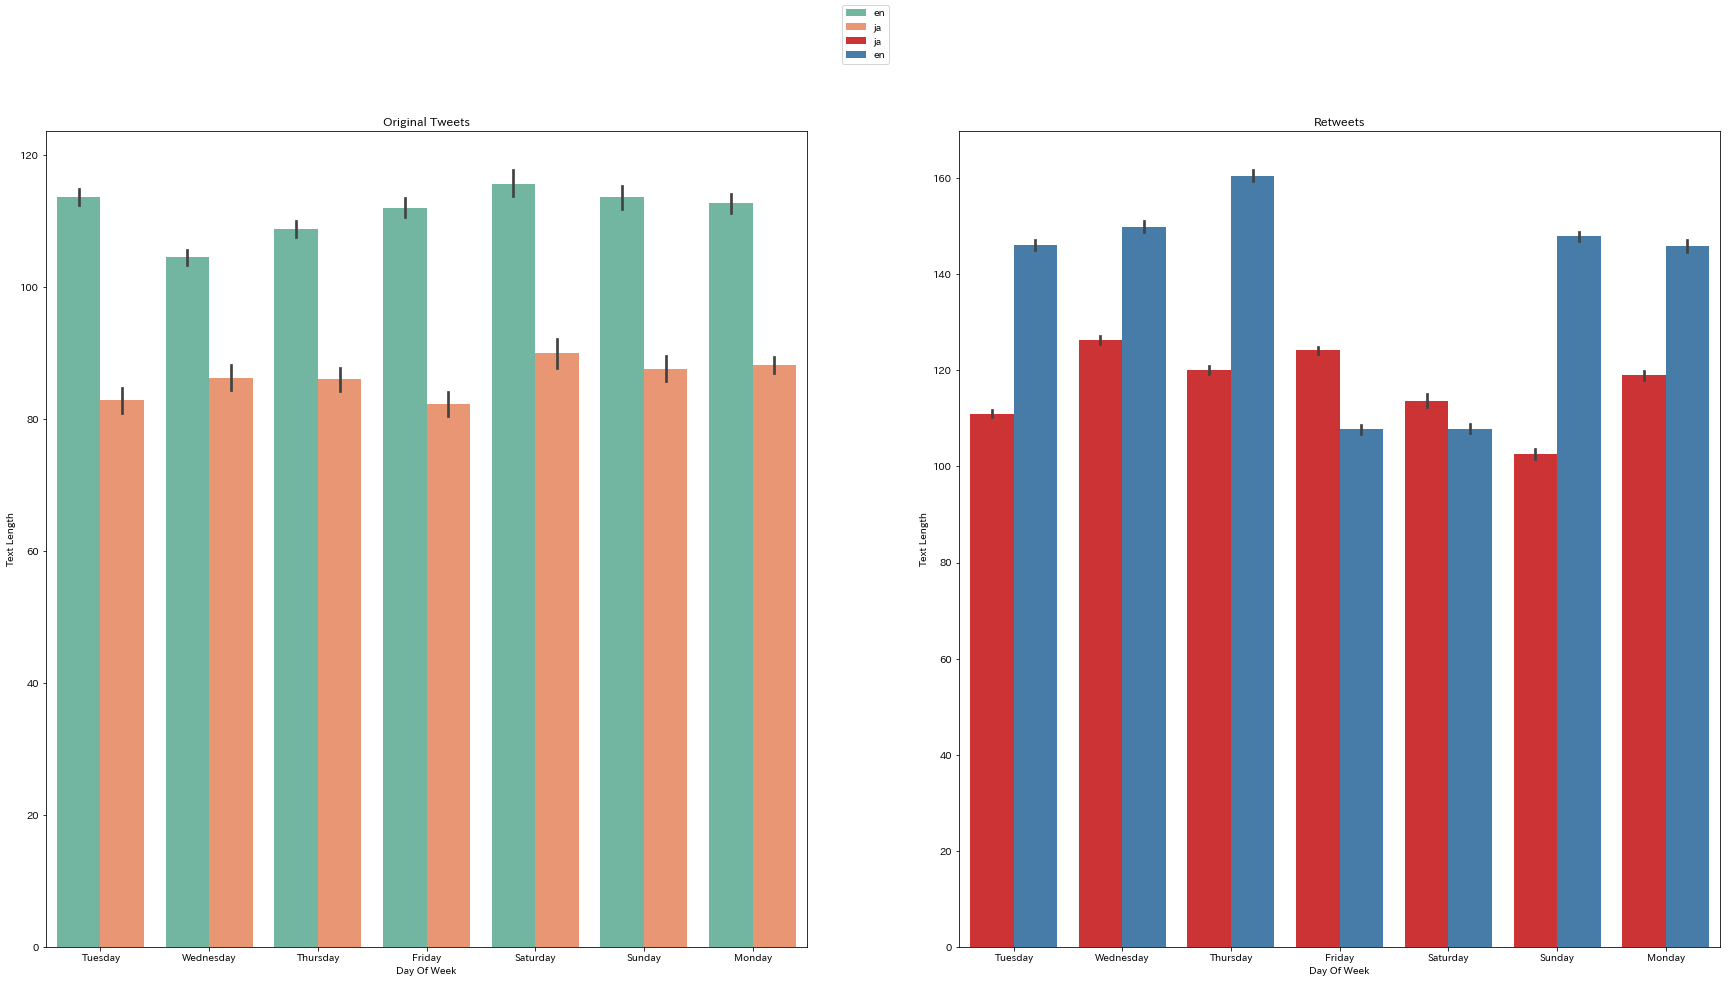

In [75]:
#Tweets and retweets for day of week 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,15))
sns.barplot(x="day_of_week", y= "text_length", hue = 'lang', data=original,orient='v',palette="Set2", ax=axes[0])
sns.barplot(x="day_of_week", y= "text_length", hue = 'lang', data=retweet, orient='v', palette="Set1", ax=axes[1])
axes[0].set_ylabel('Text Length')
axes[1].set_ylabel('Text Length')
axes[0].set_xlabel('Day Of Week')
axes[1].set_xlabel('Day Of Week')
axes[0].set_title('Original Tweets')
axes[1].set_title('Retweets')
fig.legend(loc='upper center')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.show()

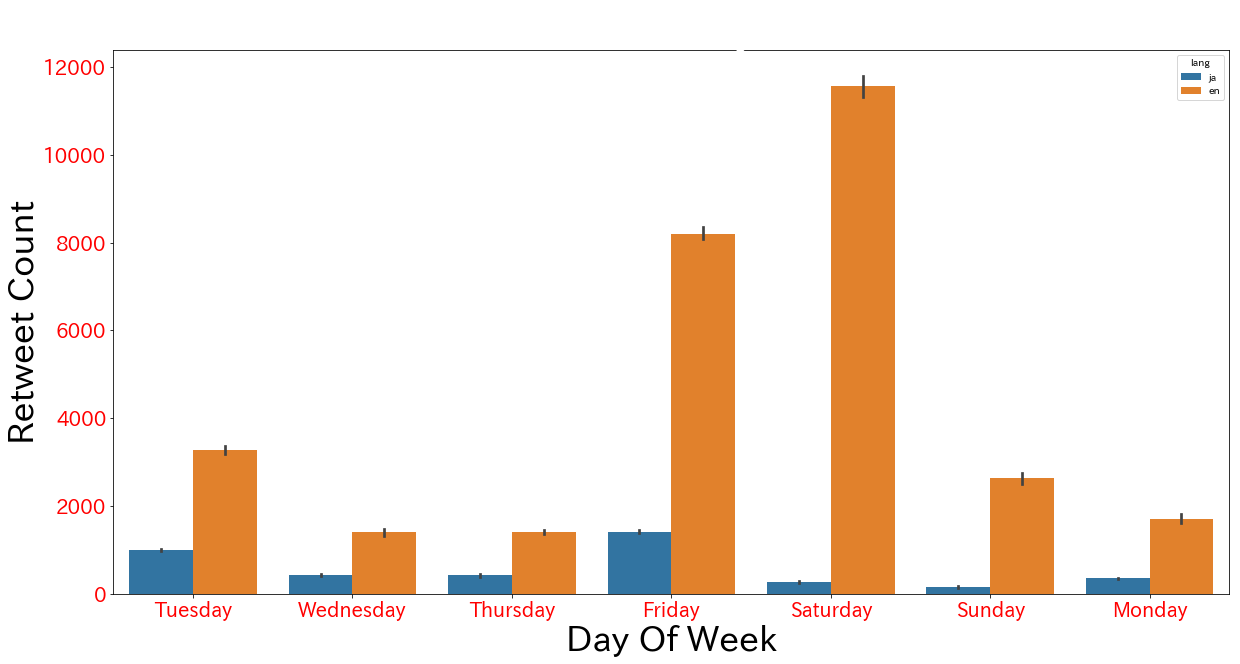

In [76]:
#All Tweets 
plt.figure(figsize=(20,10))
ax = sns.barplot(x = 'day_of_week',y = 'rt_retweet_count', hue= 'lang', data = df)
plt.xticks( fontsize = 20, color = 'red')
plt.yticks(fontsize = 20, color = 'red')
plt.xlabel('Day Of Week', fontsize=35)
plt.ylabel('Retweet Count', fontsize=35)
plt.title('Retweet and day of Week ',fontsize = 50, color = 'white')
plt.show()

In [77]:
orig_freq = pd.DataFrame(original['created_at_day'].value_counts().reset_index())
re_freq = pd.DataFrame(retweet['created_at_day'].value_counts().reset_index())
orig_freq = orig_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)
re_freq = re_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)

In [78]:
#Original Tweets vs Retweets 
fig = go.Figure()
fig.add_trace(go.Scatter(x=orig_freq['date'], y=orig_freq['count'], name="Original",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=re_freq['date'], y=re_freq['count'], name="Retweet",
                         line_color='red'))

fig.update_layout(title_text='Tweet Count by Day', width=1200,
    height=800, xaxis_rangeslider_visible=True)

fig.show()

In [87]:
#Japanese Users
original = df_ja[df_ja['retweet'] == 0]
retweet = df_ja[df_ja['retweet'] == 1]
original['created_at'] = pd.to_datetime(original['created_at'], utc=True)
retweet['created_at'] = pd.to_datetime(retweet['created_at'], utc=True)

original['created_at_day'] = original['created_at'].dt.floor('d')
retweet['created_at_day'] = retweet['created_at'].dt.floor('d')
orig_freq = pd.DataFrame(original['created_at_day'].value_counts().reset_index())
re_freq = pd.DataFrame(retweet['created_at_day'].value_counts().reset_index())
orig_freq = orig_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)
re_freq = re_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)

In [88]:
#Original Tweets vs Retweets Japanese
fig = go.Figure()
fig.add_trace(go.Scatter(x=orig_freq['date'], y=orig_freq['count'], name="Original Tweet",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=re_freq['date'], y=re_freq['count'], name="Retweet",
                         line_color='red'))

fig.update_layout(title_text='Tweet Count by Day Japanese Users', width=1200,
    height=800, xaxis_rangeslider_visible=True)

fig.show()

In [90]:
#English Users
original = df_en[df_en['retweet'] == 0]
retweet = df_en[df_en['retweet'] == 1]
original['created_at'] = pd.to_datetime(original['created_at'], utc=True)
retweet['created_at'] = pd.to_datetime(retweet['created_at'], utc=True)
original['created_at_day'] = original['created_at'].dt.floor('d')
retweet['created_at_day'] = retweet['created_at'].dt.floor('d')
orig_freq = pd.DataFrame(original['created_at_day'].value_counts().reset_index())
re_freq = pd.DataFrame(retweet['created_at_day'].value_counts().reset_index())
orig_freq = orig_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)
re_freq = re_freq.rename(columns={'index':'date','created_at_day':'count'}).sort_values('date').reset_index(drop=True)

In [91]:
#Original Tweets vs Retweets Japanese
fig = go.Figure()
fig.add_trace(go.Scatter(x=orig_freq['date'], y=orig_freq['count'], name="Original Tweet Count",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=re_freq['date'], y=re_freq['count'], name="Retweet Count",
                         line_color='red'))

fig.update_layout(title_text='Tweet Count by Day English Users', width=1200,
    height=800, xaxis_rangeslider_visible=True)

fig.show()

In [92]:
#created a min max dataframe 
df1 = df.loc[:,['created_at','rt_retweet_count']]
df1['created_at'] = pd.to_datetime(df1['created_at']).dt.floor('d')
dfhigh = df1.groupby('created_at', as_index=False)['rt_retweet_count'].max()
dfmean = df1.groupby('created_at', as_index=False)['rt_retweet_count'].mean()

In [93]:
#Time Series of total retweets 
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfhigh.created_at, y=dfhigh['rt_retweet_count'], name="Retweet High",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dfmean.created_at, y=dfmean['rt_retweet_count'], name="Retweet Mean",
                         line_color='red'))

fig.update_layout(title_text='Time Series Retweet Count by Day', width=1200,
    height=800, xaxis_rangeslider_visible=True)

fig.show()

In [94]:
#Favorite count mean and high 
df1 = df.loc[:,['created_at','rt_user_favorites_count']]

df1['created_at'] = pd.to_datetime(df1['created_at']).dt.floor('d')
dfhigh = df1.groupby('created_at', as_index=False)['rt_user_favorites_count'].max()
dfmean = df1.groupby('created_at', as_index=False)['rt_user_favorites_count'].mean()

In [95]:
#favorite count
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfhigh.created_at, y=dfhigh['rt_user_favorites_count'], name="Favorite High",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dfmean.created_at, y=dfmean['rt_user_favorites_count'], name="Favorite Mean",
                         line_color='red'))

fig.update_layout(title_text='Time Series Favorite Count by Day', width=1200,
    height=800, xaxis_rangeslider_visible=True)

fig.show()

### Word Counting 

In [96]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.feature_extraction import text 
#original tweets 
original_en = df_en[df_en['retweet'] == 0]
original_ja = df_ja[df_ja['retweet'] == 0]
#retweets
retweet_en = df_en[df_en['retweet'] == 1]
retweet_ja = df_ja[df_ja['retweet'] == 1]



In [97]:
#Add stop words for disneyland,disneysea etc... 
add_stop_words = ['disneyland','THIS','forum','disney','going','time','resort','tokyo','paris','california','disneysea','florida','disneylands','youre',
                 'mouse','anaheim','disneys','parks','angeles', '𝚃𝙷𝙸𝚂', 'park', 'forwarding', 'fortified', 'just', 'forward','𝙻𝙾𝙾𝙺','forwardlike','forthcoming',
                 'youd', 'world', 'year', 'week', 'day', 'forums', 'forththey', 'forwinnie', '𝙥𝙤𝙨𝙩𝙚𝙙', 'forth', 'forwith', 'fortnights','fortnight','fortnite',
                  'fortitude','fortress','fortunate','fort','fortunately','fortune','forsure','forwar','forwards','𝙘𝙩𝙤𝙗𝙚𝙧','forzen','forsee','foshan','forrest', 
                  'fosho','foster', 'forreal', 'this','with', 'that', 'been', 'have', 'from','when','japan', 'into','your']


In [98]:
#Document-term matrix
cv = CountVectorizer(stop_words=add_stop_words)
dtm_en = cv.fit_transform(original_en.clean_text_count)
dtm_en = pd.DataFrame(dtm_en.toarray(), columns=cv.get_feature_names())
dtm_en.index = original_en.index
dtm_en = dtm_en.transpose()

In [99]:
#top 30 words for each tweet 
top_dict = {}
for c in dtm_en.columns:
    top = dtm_en[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
#word count
words = []
for tweet in dtm_en.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [100]:
en_count = pd.DataFrame(Counter(words).most_common())
en_count.rename(columns={0:'word',1:'count'}, inplace = True)
en_count50 = en_count.head(50)

In [101]:
#Document-term matrix for retweet 
cv = CountVectorizer(stop_words=add_stop_words)
dtm_en_r = cv.fit_transform(retweet_en.clean_text_count)
dtm_en_r = pd.DataFrame(dtm_en_r.toarray(), columns=cv.get_feature_names())
dtm_en_r.index = retweet_en.index
dtm_en_r = dtm_en_r.transpose()

In [102]:
#top 30 words for each retweet 
top_dict = {}
for c in dtm_en_r.columns:
    top = dtm_en_r[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
#word count
words = []
for tweet in dtm_en_r.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [103]:
en_count_r = pd.DataFrame(Counter(words).most_common())
en_count_r.rename(columns={0:'word',1:'count'}, inplace = True)
en_count50_r = en_count_r.head(50)

In [104]:
#English word count of original tweets 
word = list(en_count50['word'])
counts = list(en_count50['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,en_count50['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'teal', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(en_count50)

columns2 = [TableColumn(field = 'word', title = 'Words'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout2 = row(p2, data_table2)

tab1 = Panel(child=layout2, title="Top 50 Words Original Tweets")

#English word count of retweets 

word = list(en_count50_r['word'])
counts = list(en_count50_r['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,en_count50_r['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'blue', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(en_count50_r)

columns2 = [TableColumn(field = 'word', title = 'Words'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout = row(p2, data_table2)

tab2 = Panel(child=layout, title="Top 50 Words Retweets")

tabs = Tabs(tabs=[ tab1, tab2])
show(tabs)

In [105]:
#stop words for Japanese Translated 
#Add stop words for disneyland,disneysea etc... 
stop_words_t = ['disneyland','THIS','forum','disney','going','time','resort','tokyo','paris','california','disneysea','florida','disneylands','youre',
                 'mouse','anaheim','disneys','parks','angeles', '𝚃𝙷𝙸𝚂', 'park', 'forwarding', 'fortified', 'just', 'forward','𝙻𝙾𝙾𝙺','forwardlike','forthcoming',
                 'youd', 'world', 'year', 'week', 'day', 'mickey', 'tdr', 'tdr_md', 'minnie' ,'forums', 'forththey', 'forwinnie', '𝙥𝙤𝙨𝙩𝙚𝙙', 'forth', 'forwith',
                 'gran', 'graclas', 'gras', 'grafrom', 'tdr_now','wwwwww', 'gotten', 'graba', 'urayasu', 'android', 'atdisneyland', 'from', 'this','with',
               'that','because', 'have', 'chiba', 'there', 'zhao', 'land']


In [106]:
#Japanese Users Original tweets Translated 
cv = CountVectorizer(stop_words=stop_words_t)
dtm_ja = cv.fit_transform(original_ja.tran_clean_text_count)
dtm_ja = pd.DataFrame(dtm_ja.toarray(), columns=cv.get_feature_names())
dtm_ja.index = original_ja.index
dtm_ja = dtm_ja.transpose()

In [107]:
#top 30 words for each tweet 
top_dict = {}
for c in dtm_ja.columns:
    top = dtm_ja[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

#word count     
words = []
for tweet in dtm_ja.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [108]:
ja_count = pd.DataFrame(Counter(words).most_common())
ja_count.rename(columns={0:'word',1:'count'}, inplace = True)
ja_count50 = ja_count.head(50)

In [109]:
#Japanese Users retweets Translated 
cv = CountVectorizer(stop_words=stop_words_t)
dtm_ja_r = cv.fit_transform(retweet_ja.tran_clean_text_count)
dtm_ja_r = pd.DataFrame(dtm_ja_r.toarray(), columns=cv.get_feature_names())
dtm_ja_r.index = retweet_ja.index
dtm_ja_r = dtm_ja_r.transpose()

In [110]:
#top 30 words for each tweet 
top_dict = {}
for c in dtm_ja_r.columns:
    top = dtm_ja_r[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

#word count     
words = []
for tweet in dtm_ja_r.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [111]:
ja_count_r = pd.DataFrame(Counter(words).most_common())
ja_count_r.rename(columns={0:'word',1:'count'}, inplace = True)
ja_count50_r = ja_count_r.head(50)

In [112]:
#original translated Japanese
word = list(ja_count50['word'])
counts = list(ja_count50['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,ja_count50['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'teal', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(ja_count50)

columns2 = [TableColumn(field = 'word', title = 'Words'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout2 = row(p2, data_table2)

tab1 = Panel(child=layout2, title="Top 50 Words Translated Original Tweets")



#Japansese Translated word count of retweets 

word = list(ja_count50_r['word'])
counts = list(ja_count50_r['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,ja_count50_r['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'blue', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(ja_count50_r)

columns2 = [TableColumn(field = 'word', title = 'Words'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout = row(p2, data_table2)

tab2 = Panel(child=layout, title="Top 50 Words Translated Retweets")

tabs = Tabs(tabs=[ tab1, tab2])
show(tabs)

In [113]:
#original tweets Japanese
import MeCab
m = MeCab.Tagger("-O wakati")
text = original_ja['clean_text_count']
text = list(text)
text = [m.parse(x).split() for x in text]
original_ja['clean_text_count_token'] = text
original_ja['clean_text_count_token'] = original_ja['clean_text_count_token'].astype(str)
original_ja['clean_text_count_token'] = original_ja['clean_text_count_token'].str.replace('\'', '')

In [114]:
#rewteets Japanese 
m = MeCab.Tagger("-O wakati")
text_r = retweet_ja['clean_text_count']
text_r = list(text_r)
text_r = [m.parse(x).split() for x in text_r]
retweet_ja['clean_text_count_token'] = text_r
retweet_ja['clean_text_count_token'] = retweet_ja['clean_text_count_token'].astype(str)
retweet_ja['clean_text_count_token'] = retweet_ja['clean_text_count_token'].str.replace('\'', '')

In [115]:
stop_words_ja = ['東京','ディズニーシー','ディズニー','𝕃𝕒𝕟𝕕','ディズニーランド','けど','イン','です', '𝔻𝕚𝕤𝕟𝕖𝕪','in','ios','android','浦安','リゾート','disneyland',
                '今日', 'この', 'ので', 'さん', 'at', 'im', 'disneysea', 'ミッキー', 'tdr', 'ミニー', 'tokyo','𝐷𝑖𝑠𝑛𝑒𝑦','https', '𐤔𐤔', 'it', 'to', 'th', 'ﾟﾟ',
                'から', 'たら', 'これ', '千葉', 'ある', 'って', 'する', 'シー', 'ちゃん', 'でも', 'モン', 'まし', 'そう', 'いる', 'だっ', 'でき', 'てる', 'すぎ', 'なら',
                'より', 'ため', 'ランド', 'まで','じゃ']

In [116]:
#Original Tweets Japanese Langauge 
cv = CountVectorizer(stop_words = stop_words_ja)
dtm_jao = cv.fit_transform(original_ja.clean_text_count_token)
dtm_jao = pd.DataFrame(dtm_jao.toarray(), columns=cv.get_feature_names())
dtm_jao.index = original_ja.index
dtm_jao = dtm_jao.transpose()

In [117]:
#Top Words Original tweets 
top_dict = {}
for c in dtm_jao.columns:
    top = dtm_jao[c].sort_values(ascending=False).head(50)
    top_dict[c]= list(zip(top.index, top.values))
words = []
for tweet in dtm_jao.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [118]:
jao_count = pd.DataFrame(Counter(words).most_common())
jao_count.rename(columns={0:'word',1:'count'}, inplace = True)
jao_count50 = jao_count.head(50)
jao_count50
transjao = pd.read_csv('jao_50trans.csv', header = None)
transjao = transjao.astype(str)
jao_count50['translated_word'] = transjao
jao_count50['translated_word'] = jao_count50['translated_word'].str.replace('\d+', '')

In [119]:
#Retweets Japanese language
cv = CountVectorizer(stop_words = stop_words_ja)
dtm_jao_r = cv.fit_transform(retweet_ja.clean_text_count_token)
dtm_jao_r = pd.DataFrame(dtm_jao_r.toarray(), columns=cv.get_feature_names())
dtm_jao_r.index = retweet_ja.index
dtm_jao_r = dtm_jao_r.transpose()

In [120]:
#Top Words retweets 
top_dict = {}
for c in dtm_jao_r.columns:
    top = dtm_jao_r[c].sort_values(ascending=False).head(50)
    top_dict[c]= list(zip(top.index, top.values))
words = []
for tweet in dtm_jao_r.columns:
    top = [word for (word, count) in top_dict[tweet] if count != 0]
    for t in top:
        words.append(t)

In [121]:
jao_count_r = pd.DataFrame(Counter(words).most_common())
jao_count_r.rename(columns={0:'word',1:'count'}, inplace = True)
jao_count50_r = jao_count_r.head(50)
jao_count_r.head(50)
transjao_r = pd.read_csv('jao_50trans_r.csv', header = None)
transjao_r = transjao_r.astype(str)
jao_count50_r['translated_word'] = transjao_r
jao_count50_r['translated_word'] = jao_count50_r['translated_word'].str.replace('\d+', '')

In [122]:
word = list(jao_count50['word'])
counts = list(jao_count50['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,jao_count50['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words Original Tweets",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'teal', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(jao_count50)

columns2 = [TableColumn(field = 'word', title = 'Words'),
            TableColumn(field = 'translated_word', title= 'Translation'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout2 = row(p2, data_table2)
tab1 = Panel(child=layout2 , title="Top 50 Words Original Japanese")



#Japanese word count of retweets 

word = list(jao_count50_r['word'])
counts = list(jao_count50_r['count'])

source = ColumnDataSource(data=dict(word=word, counts=counts))

p2 = figure(x_range=word, y_range=(0,jao_count50_r['count'][0]+100),  plot_width=1200, plot_height=1000, title="Top 50 words Retweets",
           toolbar_location='below', tools="pan,wheel_zoom,box_zoom,reset")


p2.vbar(x='word', top='counts', width=0.9, color = 'lightslategray', source=source)
p2.title.align = 'center'
p2.xgrid.grid_line_color = None
p2.xaxis.major_label_orientation = "vertical"
p2.left[0].formatter.use_scientific = False
p2.add_tools(HoverTool(tooltips=[("Word", "@word"), ("Total Count", "@counts")]))

p2.title.text_font_size = '20pt'
p2.xaxis.axis_label="Word"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.xaxis.major_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_color = "black"
p2.yaxis.axis_label="Count"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.yaxis.major_label_text_font_size = "15pt"
p2.yaxis.axis_label_text_color = "black"

tbsource2 = ColumnDataSource(jao_count50_r)

columns2 = [TableColumn(field = 'word', title = 'Words'),
            TableColumn(field = 'translated_word', title= 'Translation'),
          TableColumn(field = 'count', title = 'Count')]
data_table2 = DataTable(source = tbsource2, columns = columns2, width = 600, height = 600)

layout = row(p2, data_table2)

tab2 = Panel(child=layout, title="Top 50 Words Retweets Japanese")

tabs = Tabs(tabs=[ tab1, tab2])
show(tabs)